In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from einops import rearrange
from pytorch_lightning import seed_everything
from torch.autocast_mode import autocast
from ldm.util import instantiate_from_config
from ldm.models.diffusion.plms import PLMSSampler

seed_everything(42)

config = OmegaConf.load("../configs/stable-diffusion/v1-inference.yaml")
pl_sd = torch.load("../models/ldm/stable-diffusion-v1/model.ckpt", map_location="cpu")
model = instantiate_from_config(config.model)
m, u = model.load_state_dict(pl_sd["state_dict"], strict=False)
model.cuda()
model.eval()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = PLMSSampler(model)

def run(prompt):
	with torch.no_grad():
		with autocast("cuda"):
			with model.ema_scope():
				uc = model.get_learned_conditioning([""])
				c = model.get_learned_conditioning([prompt])
				shape = [4, 512 // 8, 512 // 8]
				samples_ddim, _ = sampler.sample(S=50,
													conditioning=c,
													batch_size=1,
													shape=shape,
													verbose=False,
													unconditional_guidance_scale=7.5,
													unconditional_conditioning=uc,
													eta=0.0,
													x_T=None)

				x_samples_ddim = model.decode_first_stage(samples_ddim)
				x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
				x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

				# x_checked_image, has_nsfw_concept = check_safety(x_samples_ddim)
				x_checked_image = x_samples_ddim

				x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)

				for x_sample in x_checked_image_torch:
					x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
					img = Image.fromarray(x_sample.astype(np.uint8))
					display(img)


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


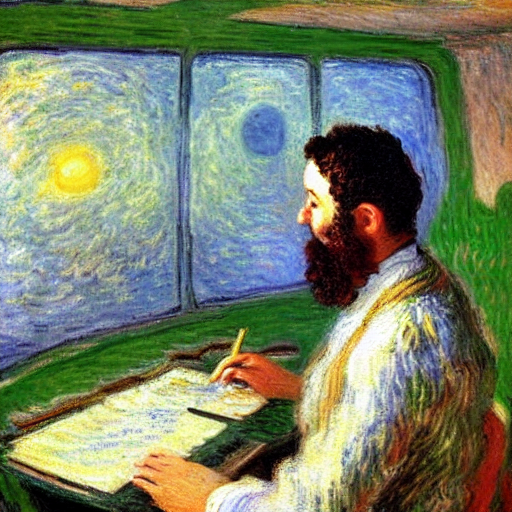

In [10]:
run("""
A programmer working on a notebook, inside a spaceship.
The planet Jupiter is in the background.
Impressionist painting by Claude Monet.
""")